## Making Plots for the paper with Altair

In [1]:
import altair as alt
alt.renderers.enable("notebook")
#alt.data_transformers.enable('json')
import pandas as pd
import numpy as np


In [9]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [10]:
lc = pd.read_json("gx339_test_lc.json", orient="records")
lc_bin = pd.read_json("gx339_binned_test_lc.json", orient="records")

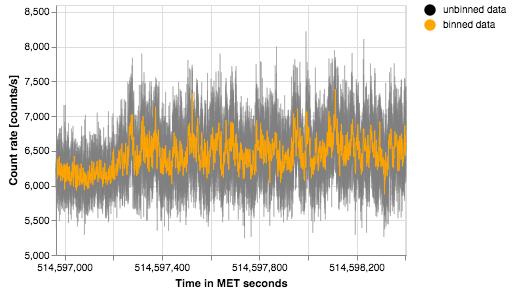

In [16]:
color_scale = alt.Scale(domain=["unbinned data", 'binned data'],
                        range=['black', 'orange'])


lc_unbinned = alt.Chart("gx339_test_lc.json").mark_line(color="grey").encode(
    x=alt.X("time:Q", scale=alt.Scale(nice=False), axis=alt.Axis(title="Time in MET seconds")),
    y=alt.Y("countrate:Q", scale=alt.Scale(zero=False, nice=False, domain=(5000, 8600)), 
            axis=alt.Axis(title="Count rate [counts/s]")),
    size=alt.value(0.4)
)

lc_binned = alt.Chart("gx339_binned_test_lc.json").mark_line(point=True).encode(
    x=alt.X("time:Q", scale=alt.Scale(nice=False), axis=alt.Axis(title="Time in MET seconds")),
    y=alt.Y("countrate:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="Count rate [counts/s]")),
    color = alt.Color("label:N", scale=color_scale, title=""),
    size=alt.value(1)
)

layer = alt.layer(lc_unbinned, lc_binned).properties(
    width=350,
    height=250)


layer

Let's also plot the PSD:

In [17]:
psd = pd.read_csv("gx339_psd_concat.csv")

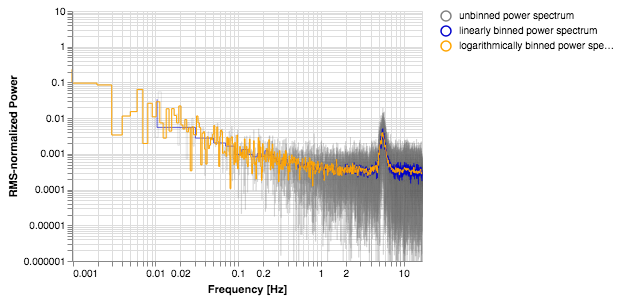

In [18]:
labels = ["unbinned power spectrum", "linearly binned power spectrum", "logarithmically binned power spectrum"]

ps_color_scale = alt.Scale(domain = labels,
                           range=["grey", "mediumblue", "orange"])

size_scale = alt.Scale(domain=labels, range=[0.2, 1, 1])


ps_chart = alt.Chart("gx339_psd_concat.json").mark_line(interpolate='step-after').encode(
    x = alt.X("freq:Q", scale=alt.Scale(nice=False, base=10, type="log"), axis=alt.Axis(title="Frequency [Hz]")),
    y = alt.Y("power:Q", scale=alt.Scale(base=10, type="log", domain=(1e-6, 10), clamp=True), 
              axis=alt.Axis(title="RMS-normalized Power")),
    color = alt.Color("pslabel:N", scale=ps_color_scale, title=""),
    #opacity = alt.Opacity("pslabel:N", scale=ps_opacity_scale, legend=None),
    size = alt.Size("pslabel:N", scale=size_scale, legend=None)
).properties(
    width=350,
    height=250,
)

ps_chart

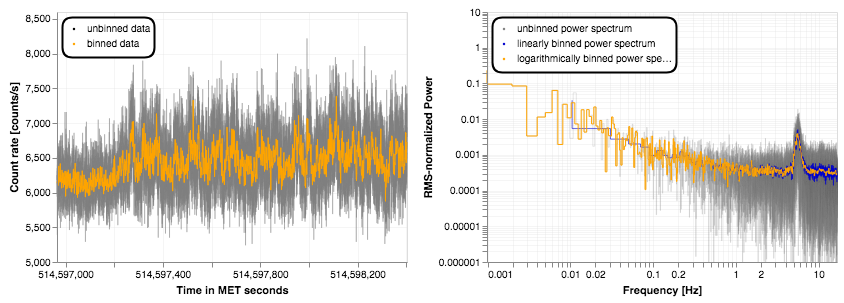

In [19]:
resolve = alt.Resolve(scale=alt.LegendResolveMap(color=alt.ResolveMode('independent')))

lc_ps_chart = alt.hconcat(layer, ps_chart, resolve=resolve
).configure_legend(
    cornerRadius=10,
    symbolSize=1,
    padding=7, strokeWidth=2, fillColor="white", strokeColor="black", offset=5, orient="top-left"
).configure_axis(gridOpacity=0.3)

lc_ps_chart

In [20]:
lc_ps_chart.save("gx339_lc_ps.svg", format="svg", scale_factor=2.0, override_data_transformer=True)

Things I'm really missing for making publication-ready plots:
* easier ways to layer and concatenate multiple data sets without having to go into contortions to get things like line widths, colours and legends right
* direct-to-pdf saving
* 

## Dynamical Power Spectrum

Let's try to plot the dynamical power spectrum. This should be fun :D 

In [8]:
dynps = pd.read_json("gx339_dynps.json", orient="records")

In [9]:
dynps.shape

(1764, 3)

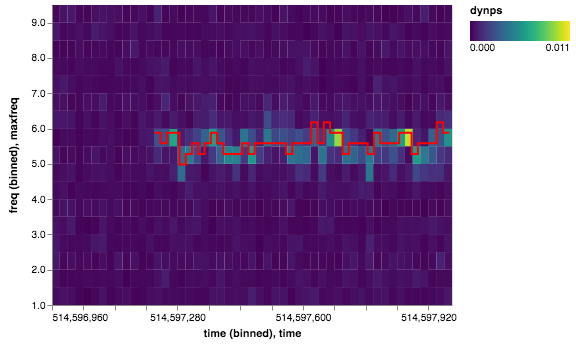

In [11]:
dynps = alt.Chart("gx339_dynps.json").mark_rect().encode(
    x=alt.X('time:Q', bin=alt.Bin(maxbins=50)),
    y=alt.Y('freq:Q', bin=alt.Bin(maxbins=30)),
    color='dynps:Q'
)

maxpos = alt.Chart("gx339_dynps_maxpos.json").mark_line(interpolate="step-after", color="red").encode(
        x = alt.X("time:Q", scale=alt.Scale(nice=False)),
        y = alt.Y("maxfreq:Q", scale=alt.Scale(nice=False))
)

#maxpos
alt.layer(dynps, maxpos)

**Note**: See the vega-lite spec `gx339_dynps_plotspec.json` for the full plot! This one will make sure that the gradient legend is vertical rather than horizontal.

## Posterior Samples and Corner Plot

Let's plot the samples and the posterior models.

First, a plot of the PSD and the posterior samples:

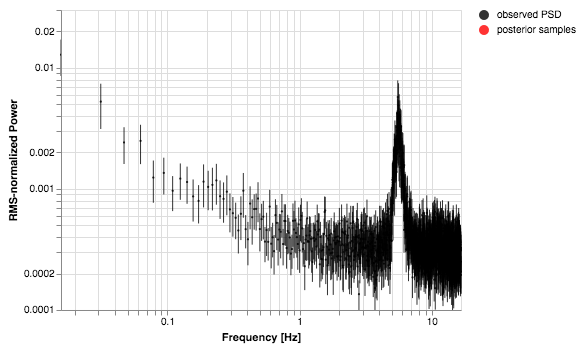

In [170]:
ydomain = (0.0001, 0.03)

psd_color_scale = alt.Scale(domain=["observed PSD", 'posterior samples'],
                        range=['black', 'red'])


psd = alt.Chart().mark_point(filled=True, size=5, color="black", opacity=0.8).encode(
    x=alt.X("freq:Q", scale=alt.Scale(nice=False, base=10, type="log"), 
            axis=alt.Axis(title="Frequency [Hz]", tickCount=5)),
    y=alt.Y("power:Q", scale=alt.Scale(base=10, type="log", domain=ydomain, 
                                       clamp=True, nice=False), 
              axis=alt.Axis(title="RMS-normalized Power", tickCount=6)),
    color=alt.Color("label:N", scale=psd_color_scale, title="")
)
errorbars = alt.Chart().mark_rule(color="black", opacity=0.8).encode(
    x = alt.X("freq:Q", scale=alt.Scale(nice=False, base=10, type="log"), 
            axis=alt.Axis(title="Frequency [Hz]", tickCount=5)),
    y = alt.Y("min_power:Q", scale=alt.Scale(base=10, type="log", domain=ydomain, 
                                             clamp=True, nice=False), 
              axis=alt.Axis(title="RMS-normalized Power", tickCount=6)),
    y2 = alt.Y2("max_power:Q")
).transform_calculate(
    min_power = "datum.power-datum.err",
    max_power = "datum.power+datum.err"

)

psd_layer = alt.layer(psd, errorbars, data="gx339_avg_ps.json")

psd_layer

Now let's plot the posterior samples:

In [171]:
models = pd.read_json("gx339_avg_ps_models.json", orient="records")

Let's plot the first model:

In [172]:
first_model = models[models["idx"] == 0]
first_model.loc[first_model.index,"idx"] = "posterior samples"

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


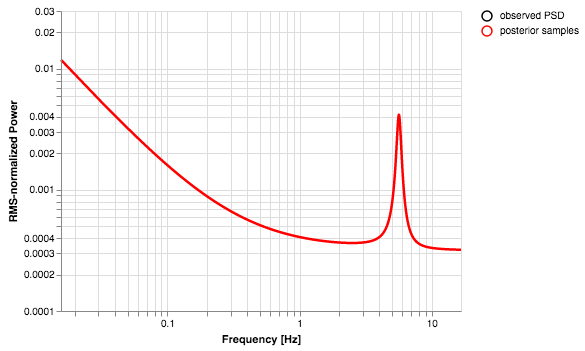

In [173]:
posterior_first = alt.Chart(first_model).mark_line().encode(
   x = alt.X("freq:Q", scale=alt.Scale(nice=False, base=10, type="log"), 
            axis=alt.Axis(title="Frequency [Hz]", tickCount=5)),
    y = alt.Y("power:Q",scale=alt.Scale(base=10, type="log", domain=ydomain, 
                                        clamp=True, nice=False), 
              axis=alt.Axis(title="RMS-normalized Power", tickCount=10)),
    size=alt.Size("idx:O", legend=None),
    color=alt.Color("label:N", scale=psd_color_scale, title="")
)

posterior_first

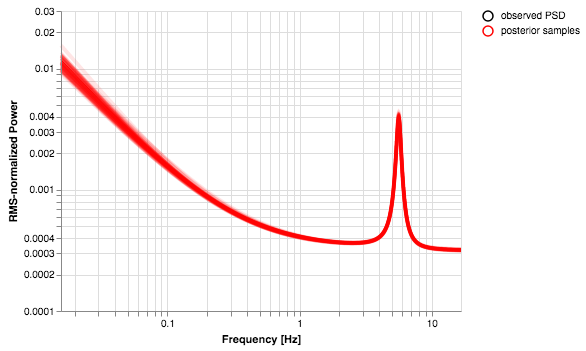

In [174]:
posteriors = alt.Chart("gx339_avg_ps_models.json").mark_line(opacity=0.1).encode(
    x = alt.X("freq:Q", scale=alt.Scale(nice=False, base=10, type="log"), 
            axis=alt.Axis(title="Frequency [Hz]", tickCount=5)),
    y = alt.Y("power:Q",scale=alt.Scale(base=10, type="log", domain=ydomain, 
                                        clamp=True, nice=False), 
              axis=alt.Axis(title="RMS-normalized Power", tickCount=10)),
    size=alt.Size("idx:O", legend=None),
    color=alt.value("red")
)

alt.layer(posterior_first,posteriors)

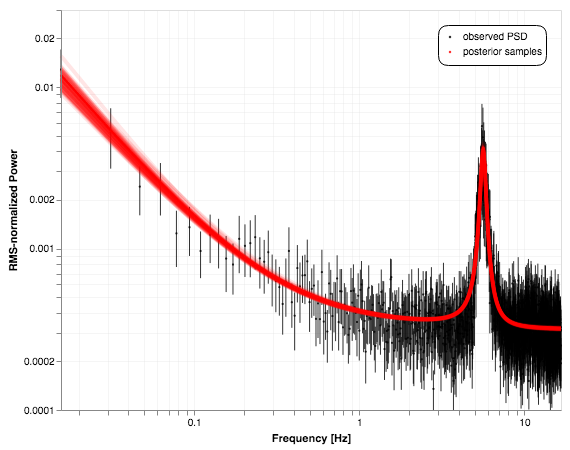

In [177]:
resolve = alt.Resolve(scale=alt.LegendResolveMap(size=alt.ResolveMode('independent')))

alt.layer(psd_layer, posterior_first, posteriors, resolve=resolve
).configure_axis(gridOpacity=0.3
).configure_legend(cornerRadius=10,
    symbolSize=1,
    padding=7, strokeWidth=1, fillColor="white", strokeColor="black", 
    offset=15, orient="top-right"
).properties(
    width=500, height=400)

Here's some code that makes corner plots:

In [185]:
def plot_scatter(data, columnx, columny, xrange=None, yrange=None, 
                 width=100, height=100, extent_factor=0.01, axlabels=None, 
                 nticks=6, opacity=0.3, truths=None, truth_color="#4682b4",
                 plot_xticks=True, plot_yticks=True):
     
    """
    Make a scatter plot in Altair of two columns.
    
    Parameters
    ----------
    
    data : pd.DataFrame
        A pandas DataFrame with the data
        
    columnx, columny : str, str
        Strings corresponding to the columns in `data` to be plotted 
        on the x- and y-axis, respectively
        
    nbins : int
        The number of bins on each axis
        
    xrange, yrange : (float, float) or None 
        The ranges for the x- and y-axes. If set to None, will be calculated
        from the data and `extent_factor`
    
    width, height: float, float
        The width and height of the output chart
        
    extent_factor : float, default 0.01
        If `xrange` and/or `yrange` are `None`, this keyword sets a parameter 
        that determines the fraction of space to leave on either side of the 
        min and max of the data points
        
    axlabels : (str, str)
        The labels for the x- and y-axis, respectively. If `None`, the axis 
        labels will be taken from `columnx` and `columny`.
        
    nticks : int, optional, default 6
        The number of labels on the x-axis
        
    opacity : float in (0, 1), optional, default 0.3
        The opacity of points in the scatter plot. 
    
    plot_xticks, plot_yticks : bool, optional, default True
        If True, plot ticks and tick labels. If False, don't 
        plot ticks and tick labels for the x- and y-axis, 
        respectively.
        
    Returns
    -------
        hist : alt.Chart object
            The resulting heatmap figure
    """
    # min and max for the x-axis
    if xrange is None:
        min_x = data[columnx].min() * (1.0 - extent_factor)
        max_x = data[columnx].max() * (1.0 + extent_factor)
        xrange = (min_x, max_x)
        
    # min and max for y-axis
    if yrange is None:
        min_y = data[columny].min() * (1.0 - extent_factor)
        max_y = data[columny].max() * (1.0 + extent_factor)
        yrange = (min_y, max_y)

    # format for x and y-axis:
    if xrange[1] < 0.01 or xrange[1] > 100:
        xformat = ".1e"
    else:
        xformat = ".3f"
        
    if yrange[1] < 0.01 or yrange[1] > 100:
        yformat = ".1e"
    else:
        yformat = ".3f"
        
    # get the axis labels
    if axlabels is None:
        axlabels = (columnx, columny)
    
    # figure out whether to plot ticks and tick labels
    if plot_xticks:
        xl=True
        xt=True
    else:
        xl=False
        xt=False
    
    if plot_yticks:
        yl = True
        yt = True
    else:
        yl = False
        yt = False
        
    # angle for the labels
    la = 0

    # make the plot
    hist = alt.Chart(data[[columnx, columny]]).mark_point(filled=True, color="grey", opacity=opacity, size=3).encode(
                x=alt.X('%s:Q'%columnx, axis=alt.Axis(format="%s"%xformat, 
                                                      labelAngle=la-90,
                                                      tickCount=nticks,
                                                      labels=xl, ticks=xt), 
                         title=axlabels[0], scale=alt.Scale(domain=xrange, nice=False, zero=False)),
                y=alt.Y('%s:Q'%columny, axis=alt.Axis(format="%s"%yformat, 
                                                      labelAngle=la,
                                                      labels=yl, ticks=yt), 
                        title=axlabels[1], scale=alt.Scale(domain=yrange, nice=False, zero=False)),
                #color=alt.Color('hist:Q', scale=alt.Scale(scheme="greys"), legend=None)
            ).properties(
                width=width,
                height=height
            )
    if truths is not None:
        truth_df = pd.DataFrame(truths, index=[0])
        xrule = alt.Chart(truth_df).mark_rule(color=truth_color, opacity=0.8).encode(
            x = alt.X("%s:Q"%columnx, axis=alt.Axis(format="%s"%xformat, 
                                                  labelAngle=la-90, 
                                                  grid=False, 
                                                  tickCount=nticks,
                                                  labels=xl, ticks=xt),
                     title=axlabels[0], scale=alt.Scale(domain=xrange, nice=False)),
            size=alt.value(2)
            ) 
        yrule = alt.Chart(truth_df).mark_rule(color=truth_color, opacity=0.8).encode(
            y = alt.Y("%s:Q"%columny, axis=alt.Axis(format="%s"%yformat, 
                                                  labelAngle=la, 
                                                  grid=False, 
                                                  tickCount=nticks,
                                                  labels=yl, ticks=yt),
                     title=axlabels[1], scale=alt.Scale(domain=yrange, nice=False)),
            size=alt.value(2)
            ) 

        return alt.layer(hist, xrule, yrule)
    else:
        return hist

def plot_hist2d(data, columnx, columny, nbins=20, xrange=None, yrange=None, 
                width=100, height=100, extent_factor=0.01, axlabels=None, 
                plot_xticks=True, plot_yticks=True,
                nticks=6, truths=None, truth_color="#4682b4"):
    
    """
    Plot a 2D histogram in Altair with a fixed number of bins.
    
    Parameters
    ----------
    
    data : pd.DataFrame
        A pandas DataFrame with the data
        
    columnx, columny : str, str
        Strings corresponding to the columns in `data` to be plotted 
        on the x- and y-axis, respectively
        
    nbins : int
        The number of bins on each axis
        
    xrange, yrange : (float, float) or None 
        The ranges for the x- and y-axes. If set to None, will be calculated
        from the data and `extent_factor`
    
    width, height: float, float
        The width and height of the output chart
        
    extent_factor : float, default 0.01
        If `xrange` and/or `yrange` are `None`, this keyword sets a parameter 
        that determines the fraction of space to leave on either side of the 
        min and max of the data points
        
    axlabels : (str, str)
        The labels for the x- and y-axis, respectively. If `None`, the axis 
        labels will be taken from `columnx` and `columny`.
        
    nticks : int, optional, default 6
        The number of labels on the x-axis
        
    truths : dict, optional, default None
        Dictionary with true values for the `data`. Useful when testing 
        algorithms on simulated data.
        
    Returns
    -------
        hist : alt.Chart object
            The resulting heatmap figure
    """
    # min and max for the x-axis
    if xrange is None:
        min_x = data[columnx].min() * (1.0 - extent_factor)
        max_x = data[columnx].max() * (1.0 + extent_factor)
        xrange = (min_x, max_x)
        
    # min and max for y-axis
    if yrange is None:
        min_y = data[columny].min() * (1.0 - extent_factor)
        max_y = data[columny].max() * (1.0 + extent_factor)
        yrange = (min_y, max_y)
        
    xstep = (xrange[1]-xrange[0])/(nbins)
    ystep = (yrange[1]-yrange[0])/(nbins)
        
    # bins are bin _edges_, so need to be nbins+1
    xbins = np.arange(xrange[0], xrange[1]+0.5*xstep, xstep)
    ybins = np.arange(yrange[0], yrange[1]+0.5*ystep, ystep)

    # grid for the 2D histogram
    x, y = np.meshgrid(xbins[:-1]+0.5*xstep, ybins[:-1]+0.5*ystep)

    # create the 2D histogram
    hist, xedges, yedges = np.histogram2d(data[columnx], data[columny], bins=[xbins, ybins])

    # unravel the x- and y-bins
    xravel = x.ravel()
    yravel = y.ravel()

    # unravel the histogram
    histravel = hist.ravel()

    # put everything into a temporary DataFrame
    histdf = pd.DataFrame({"%s"%columnx:xravel, "%s"%columny:yravel, "hist":histravel})
    
    # format for x and y-axis:
    if xrange[1] < 0.01 or xrange[1] > 100:
        xformat = ".1e"
    else:
        xformat = ".3f"
        
    if yrange[1] < 0.01 or yrange[1] > 100:
        yformat = ".1e"
    else:
        yformat = ".3f"
        
    # get the axis labels
    if axlabels is None:
        axlabels = (columnx, columny)
        
    if plot_xticks:
        xl=True
        xt=True
    else:
        xl=False
        xt=False
    
    if plot_yticks:
        yl = True
        yt = True
    else:
        yl = False
        yt = False
        
    # angle for the labels
    la = 0
    
    # make the plot
    hist = alt.Chart(histdf).mark_rect().encode(
                x=alt.X('%s:Q'%columnx, axis=alt.Axis(format="%s"%xformat, labelAngle=la-90, 
                                                      tickCount=nticks, labels=xl, ticks=xt), 
                        bin=alt.Bin(step=xstep), title=axlabels[0],
                       scale = alt.Scale(domain=xrange, nice=False, zero=False)),
                y=alt.Y('%s:Q'%columny, axis=alt.Axis(format="%s"%yformat, labelAngle=la,
                                                     labels=yl, ticks=yt), 
                        bin=alt.Bin(step=ystep), title=axlabels[1],
                        scale=alt.Scale(domain=yrange, nice=False, zero=False)),
                color=alt.Color('hist:Q', scale=alt.Scale(scheme="greys"), legend=None)
            ).properties(
                width=width,
                height=height
            )
    
    if truths is not None:
        truth_df = pd.DataFrame(truths, index=[0])
        xrule = alt.Chart(truth_df).mark_rule(color=truth_color, opacity=0.8).encode(
            x = alt.X("%s:Q"%columnx, axis=alt.Axis(format="%s"%xformat, 
                                                    labelAngle=la-90., 
                                                    grid=False, 
                                                    tickCount=nticks,
                                                    labels=xl, ticks=xt),
                     title=axlabels[0], scale=alt.Scale(domain=xrange, nice=False)),
            size=alt.value(2)
            ) 
        yrule = alt.Chart(truth_df).mark_rule(color=truth_color, opacity=0.8).encode(
            y = alt.Y("%s:Q"%columny, axis=alt.Axis(format="%s"%yformat, 
                                                    labelAngle=la, 
                                                    grid=False, 
                                                    tickCount=nticks,
                                                    labels=yl, ticks=yt),
                     title=axlabels[1], scale=alt.Scale(domain=yrange, nice=False)),
            size=alt.value(2)
            ) 

        return alt.layer(hist, xrule, yrule)
    else:
        return hist
    
def plot_hist1d(data, label, nbins=20, xrange=None, quantiles=None,
                width=100, height=100, axlabel=None, nticks=6, bars=False, 
                truths=None, truth_color="#4682b4", plot_xticks=True):
    
    """
    Plot a 2D histogram in Altair with a fixed number of bins.
    
    Parameters
    ----------
    
    data : pd.DataFrame
        A pandas DataFrame with the data
        
    label : str
        Strings corresponding to the columns in `data` to be plotted 
        on the x- and y-axis, respectively
        
    nbins : int
        The number of bins on each axis
        
    xrange, yrange : (float, float) or None 
        The ranges for the x- and y-axes. If set to None, will be calculated
        from the data and `extent_factor`
        
    quantiles: iterable, values between 0 and 100
        A list of quantiles to plot as a dashed line on the histogram. 
        If zero, the 16% and 84% quantiles will be plotted. 
        Note: Quantiles must be given in *percent*, so between 0 and 100!
        
    width, height: float, float
        The width and height of the output chart
        
    extent_factor : float, default 0.01
        If `xrange` and/or `yrange` are `None`, this keyword sets a parameter 
        that determines the fraction of space to leave on either side of the 
        min and max of the data points
        
    axlabel : str
        The text for the x-axis (instead of the string in `label`)
        
    nticks : int, optional, default 6
        The number of ticks on the x-axis
    
    bars : boolean, optional, default False
        If False (default), plot the histogram as a line graph.
        If True, plot bars
        
    truths : float
        The true value of the parameter.
        
    truth_color : str
        A colour code (hex or string) defining the colour for the 
        line drawn at the true value.
        
    plot_xticks : boolean, optional, default True
        If True, plot ticks and tick labels on the x-axis, otherwise
        omit ticks and labels.
        
    Returns
    -------
        hist : alt.Chart object
            The resulting heatmap figure
    """
    # min and max for the x-axis
    if xrange is None:
        min_x = data[label].min()
        max_x = data[label].max()
        xrange = (min_x, max_x)

    xstep = (xrange[1]-xrange[0])/(nbins+1)
    
    xbins = np.arange(xrange[0], xrange[1]+0.5*xstep, xstep)

    # create the 2D histogram
    hist, _ = np.histogram(data[label], bins=xbins, normed=True)

    # put everything into a temporary DataFrame
    histdf = pd.DataFrame({"x_left":xbins[:-1], "x_right":xbins[1:], "hist":hist})

    # compute quantiles
    if quantiles is None:
        quantiles = np.array([0.16, 0.84])
        
    q = np.hstack([quantiles, [0.5]])
    quant = data[label].quantile(q)
    q_df = pd.DataFrame({"quantiles":quant.index, "val":quant.values})
    
    # format for x and y-axis:
    if xrange[1] < 0.01 or xrange[1] > 100:
        xformat = ".1e"
    else:
        xformat = ".3f"

    # set axis label 
    if axlabel is None:
        axlabel = label
        
    # angle for the labels
    la = 0

    if not bars:
        hist = alt.Chart(histdf).mark_line(color="black", interpolate="step-after", opacity=0.5).encode(
                x=alt.X('x_left:Q', axis=alt.Axis(format="%s"%xformat, 
                                                      labelAngle=la-90, 
                                                      grid=False, 
                                                      tickCount=nticks,
                                                      labels = plot_xticks,
                                                      ticks = plot_xticks), 
                             title=axlabel, scale=alt.Scale(domain=xrange, nice=False)),
                    #x2 = alt.X2('x_right:Q'),
                y=alt.Y("hist:Q", title="", axis=alt.Axis(format="f", labels=False, ticks=False)),
                size=alt.value(2)
                ).properties(
                    width=width,
                    height=height
                )

    else:
        hist = alt.Chart(histdf).mark_rect(color="black", opacity=0.5).encode(
                x=alt.X('x_left:Q', axis=alt.Axis(format="%s"%xformat, 
                                                      labelAngle=la-90, 
                                                      grid=False, 
                                                      tickCount=nticks,
                                                      labels = plot_xticks,
                                                      ticks = plot_xticks), 
                             title=axlabel, scale=alt.Scale(domain=xrange, nice=False)),
                    x2 = alt.X2('x_right:Q'),
                y=alt.Y("hist:Q", title="", axis=alt.Axis(format="f", labels=False, ticks=False)),
                ).properties(
                    width=width,
                    height=height
                )

    if truths is None:
        rule = alt.Chart(q_df).mark_rule(color="grey", strokeDash=[7, 7]).encode(
                x = alt.X("val:Q", axis=alt.Axis(format="%s"%xformat, 
                                                      labelAngle=la-90, 
                                                      grid=False, 
                                                      tickCount=nticks),
                         title=axlabel, scale=alt.Scale(domain=xrange, nice=False)),
                size=alt.value(1)
                ) 
    else:
        truth_df = pd.DataFrame({label:truths}, index=[0])
        rule = alt.Chart(truth_df).mark_rule(color=truth_color).encode(
            x = alt.X("%s:Q"%label, axis=alt.Axis(format="%s"%xformat, 
                                                  labelAngle=la-90, 
                                                  grid=False, 
                                                  tickCount=nticks),
                     title=axlabel, scale=alt.Scale(domain=xrange, nice=False)),
            size=alt.value(2)
            ) 

    return  alt.layer(hist, rule)

def corner(data, nbins=40, plottype="heat", quantiles = None, 
           axlabels=None, width=100, height=100, opacity=1.0, nticks=6,
           bars=False, truths=None, truth_color="#4682b4"):
    """
    Make a corner plot.
    
    Parameters
    ----------
    
    data : pd.DataFrame
        A data frame with the data
        
    nbins : int, optional, default: 40
        The number of bins for the 1D and 2D histograms
        
    plottype : str, {"heat" | "scatter"}, optional, default "heat"
        The type of plot for the 2D histograms, either "heat" for a heatmap
        or "scatter" for a scatter plot
        
    axlabels : iterable of strings, optional
        A list of optional axis labels; one for each columns in `data`. 
        If `None`, then the column names of `data` will be used
        
    width, height: int, optional, default 100 for both
        The width and height of each subplot
        
    opacity : float in (0,1), optional, default 1
        If `plottype="scatter"`, this value will be used to set the 
        opacity of each scatter point
        
    nticks : int, optional, default 6
        The number of ticks on the x-axis
        
    bars : boolean, optional, default False
        If true, plot the 1D histogram as a bar chart, 
        rather than a line chart (default)
        
    padding : int, optional, default 10
        The padding between adjacent plots
    
    Returns
    -------
    cplot : altair.Chart() object
        The Altair corner plot
    
    
    """
    
    if axlabels is None:
        axlabels = np.array(data.columns)

    c_hconcat_all = []

    for i,labelx in enumerate(data.columns):
        c_row = []
        min_x = data[labelx].min()
        max_x = data[labelx].max()
        for j, labely in enumerate(data.columns):
            if labelx == labely:
                if i < len(data.columns)-1:
                    al = "" # no label on x-axis
                    xt = False # don't plot x-ticks and labels
                else:
                    al = axlabels[i] # label on x-axis
                    xt = True # plot x-ticks and labels
                
                if truths is not None:
                    true_val = truths[labelx]
                else:
                    true_val = None
                chart = plot_hist1d(data, labelx, nbins=nbins, xrange=(min_x, max_x), 
                                    width=width, height=height, axlabel=al, 
                                    nticks=nticks, bars=bars, truths=true_val,
                                    truth_color=truth_color, plot_xticks=xt)
                c_row.append(chart)
            elif j > i:
                chart = alt.Chart()
            else:
                min_y = data[labely].min()
                max_y = data[labely].max()

                if i < len(data.columns)-1:
                    al1 = "" # x-axis label
                    px = False # don't plot x-ticks and labels
                else:
                    al1 = axlabels[j] # x-axis label
                    px = True # plot x-ticks and labels
                
                if j > 0:
                    al2 = "" # y-axis label
                    py = False # don't plot y-ticks and labels
                else:
                    al2 = axlabels[i] # y-axis label
                    py = True # plot y-ticks and labels
                    
                al = (al1, al2)
                                
                if plottype == "heat":
                    chart = plot_hist2d(data, labely, labelx, nbins=nbins, 
                                        xrange=(min_y, max_y), yrange=(min_x, max_x),
                                        width=width, height=height, extent_factor=0.0,
                                        axlabels=al, nticks=nticks, truths=truths,
                                        truth_color=truth_color,
                                        plot_xticks=px, plot_yticks=py)
                elif plottype == "scatter":
                    chart = plot_scatter(data, labely, labelx,
                                         xrange=(min_y, max_y), yrange=(min_x, max_x),
                                         width=width, height=height, extent_factor=0.0,
                                         axlabels=al, nticks=nticks, opacity=opacity,
                                         truths=truths, truth_color=truth_color,
                                         plot_xticks=px, plot_yticks=py)
                else:
                    raise ValueError("Please include a valid plot type. Options are 'heat'"+\
                                     " for a heat map and 'scatter' for a scatter plot.")
                    
                c_row.append(chart)
        c_hconcat = alt.hconcat(*c_row)
        c_hconcat_all.append(c_hconcat)

    cplot = alt.vconcat(*c_hconcat_all)
    
    return cplot

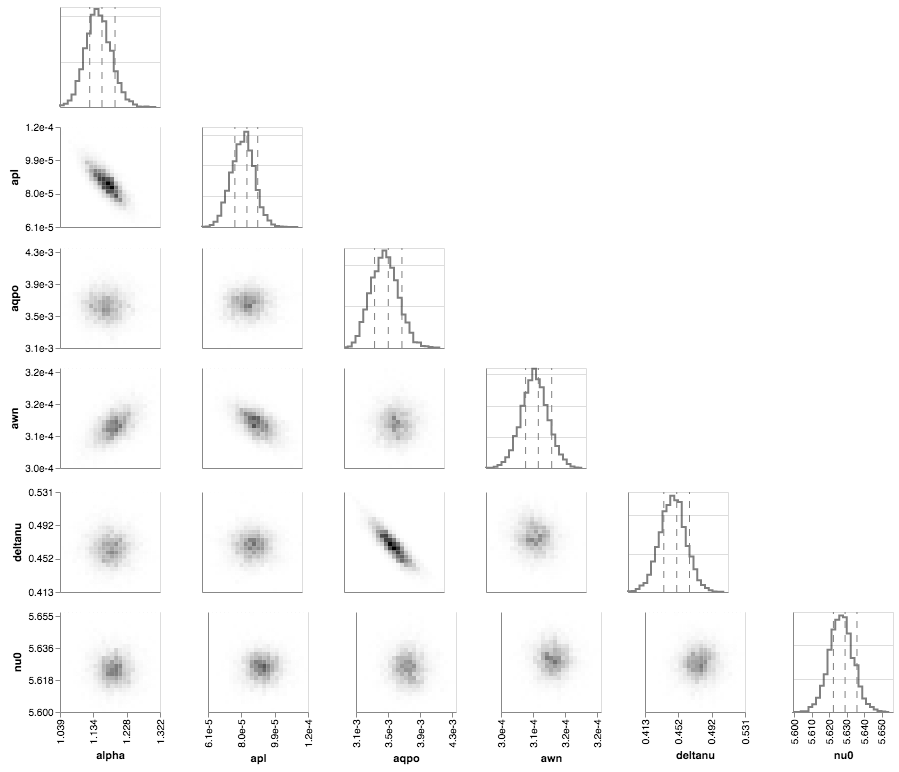

In [186]:
corner(pd.read_json("gx339_samples.json", orient="records"), nbins=25, width=100, height=100)